# Team 3 - Merchant Category Recommendation

# Feature Engineering

### Team 3

* Vinicio De Sola
* Kevin Hanna
* Pri Nonis
* Bradley Nott

Here we add engineer new features and write the files out to:

    - input/engineered_train.pkl
    - input/engineered_test.pkl

In [1]:
%matplotlib inline

import numpy                  as np
import matplotlib.pyplot      as plt
import pandas                 as pd
import matplotlib.pyplot      as plt
import matplotlib             as mpl
import lightgbm               as lgb
import seaborn                as sb
import math


from datetime                 import timedelta, datetime

from sklearn                  import metrics
from sklearn.decomposition    import PCA, SparsePCA, MiniBatchSparsePCA
from sklearn.cluster          import KMeans
from sklearn.mixture          import GaussianMixture
from sklearn.linear_model     import LinearRegression
from sklearn.metrics          import mean_squared_error
from sklearn.model_selection  import KFold
from sklearn.preprocessing    import StandardScaler

from matplotlib.colors        import LogNorm
from IPython.display          import display, HTML, Markdown

import warnings

warnings.filterwarnings('ignore')
np.random.seed(0)

# Plot formats
from cycler import cycler
import matplotlib.patches as patches
import matplotlib.mlab as mlab
import matplotlib.dates
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# Figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid


import os
print(os.listdir("./input"))

['Data_Dictionary.xlsx', 'engineered_test.pkl', 'engineered_train.pkl', 'features_importance_kfold.pkl', 'historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'selected_test.pkl', 'selected_train.pkl', 'test.csv', 'train.csv']


## Read in all the data files

In [2]:
train        = pd.read_csv('input/train.csv', parse_dates=['first_active_month']).set_index('card_id')
test         = pd.read_csv('input/test.csv',  parse_dates=['first_active_month']).set_index('card_id')
transactions_old = pd.read_csv('input/historical_transactions.csv',   parse_dates = ['purchase_date'])
transactions_new = pd.read_csv('input/new_merchant_transactions.csv', parse_dates = ['purchase_date'])

## Data Clean Up

In [3]:
# Remove Row with missing value for first_active_month
print(test.loc['C_ID_c27b4f80f7', :])
test.loc['C_ID_c27b4f80f7', 'first_active_month'] = test['first_active_month'].min()
print(test.loc['C_ID_c27b4f80f7', :])

first_active_month    NaT
feature_1               5
feature_2               2
feature_3               1
Name: C_ID_c27b4f80f7, dtype: object
first_active_month    2011-11-01 00:00:00
feature_1                               5
feature_2                               2
feature_3                               1
Name: C_ID_c27b4f80f7, dtype: object


## Baseline - Model

Our baseline model uses the data provided in the "train" dataset.

In [4]:
def calculate_baseline():
    training = train[['feature_1', 'feature_2', 'feature_3']]
    labels = train[['target']]
    
    # For reproducibility purposes
    np.random.seed(0)
    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    val_data = training.values[~mask]
    val_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_val = val_data
    y_val = val_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_reg)

    y_mean = train_labels.mean()
    y_val_mean = val_labels.mean()

    print("After fitting Linear Regression, the baseline Mean Squared Error is: {:0.3f}".format(mse))
    print("The mean of our training label is {:0.3f} and for validation {:0.3f}".format(y_mean, y_val_mean))
    
    return mse

baseline_mse = calculate_baseline()

After fitting Linear Regression, the baseline Mean Squared Error is: 14.269
The mean of our training label is -0.394 and for validation -0.393


## Feature Engineering

### Transform train first_active_month to numeric

The first_active_month is a date the shopper first made a purchase using Elo. Converting this to days would make it more useful for modelling.

In [5]:
def first_active_month_to_numeric():
    global train, test
    latest_date = max(train['first_active_month'].max(), test['first_active_month'].max()) \
                                                            + timedelta(days=1)
    train['first_active_delta_days'] = ((latest_date - train['first_active_month']).dt.days)
    test['first_active_delta_days']  = ((latest_date - test['first_active_month']).dt.days)

first_active_month_to_numeric()

# We no longer need first active month
del train['first_active_month']
del test['first_active_month']

### Binarize 'Y' and 'N' category

Convert to binary so they can be aggregated later.

In [6]:
transactions_old['category_1'] = transactions_old.category_1.eq('Y').mul(1)
transactions_new['category_1'] = transactions_new.category_1.eq('Y').mul(1)

transactions_old['authorized_flag'] = transactions_old.authorized_flag.eq('Y').mul(1)
transactions_new['authorized_flag'] = transactions_new.authorized_flag.eq('Y').mul(1)

### Create Dummy variables for encoding the data

In [7]:
train = pd.get_dummies(train, columns=['feature_1', 'feature_2'])
test = pd.get_dummies(test, columns=['feature_1', 'feature_2'])
transactions_old = pd.get_dummies(transactions_old, columns=['category_2', 'category_3'])
transactions_new = pd.get_dummies(transactions_new, columns=['category_2', 'category_3'])

### Convert Dates to Numeric

In [8]:
latest_transaction = transactions_old['purchase_date'].max()
transactions_old['month_diff'] = ((latest_transaction - \
                                   transactions_old['purchase_date']))//np.timedelta64(1, 'M')
transactions_old['month_diff'] += transactions_old['month_lag']

transactions_new['month_diff'] = ((latest_transaction - \
                                   transactions_new['purchase_date']))//np.timedelta64(1, 'M')
transactions_new['month_diff'] += transactions_new['month_lag']

### Aggregate New and Old Transactions with Train on card_id

As explained in: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [9]:
def aggregate_transaction_data():
    global train, test   
    transactions_old.loc[:, 'purchase_date'] = pd.DatetimeIndex(transactions_old['purchase_date']).\
                                      astype(np.int64) * 1e-9
    transactions_new.loc[:, 'purchase_date'] = pd.DatetimeIndex(transactions_new['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    # These aggregations will be performed on both new and old
    aggregation = {
        'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
        'subsector_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'installments': ['sum','mean'],
        'city_id': ['nunique'],
        'state_id': ['nunique'], 
        'category_1': ['sum'],
        'category_2_1.0': ['sum'],
        'category_2_2.0': ['sum'],
        'category_2_3.0': ['sum'],
        'category_2_4.0': ['sum'],
        'category_2_5.0': ['sum'],
        'category_3_A': ['sum'],
        'category_3_B': ['sum'],
        'category_3_C': ['sum'],
        'month_lag': ['mean', 'min', 'max', 'std'],
        'authorized_flag': ['sum'],
        'month_diff': ['mean', 'min', 'max', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
    }

    # Do aggregations on aggregated_old and join with training and test data
    aggregated_old = transactions_old.groupby(['card_id']).agg(aggregation)
    aggregated_old.columns = ['old_' + '_'.join(col).strip() for col in aggregated_old.columns.values]
    train = train.merge(right=aggregated_old, how='left', on='card_id')
    test = test.merge(right=aggregated_old, how='left', on='card_id')

    # Do aggregations on aggregated_new and join with training and test data
    aggregated_new = transactions_new.groupby(['card_id']).agg(aggregation)
    aggregated_new.columns = ['new_' + '_'.join(col).strip() for col in aggregated_new.columns.values]
    train = train.merge(right=aggregated_new, how='left', on='card_id')
    test = test.merge(right=aggregated_new, how='left', on='card_id')  
    
aggregate_transaction_data()

In [10]:
# Let's check our new dataframe
authorized_transactions = transactions_old[transactions_old['authorized_flag'] == 1]
display(train.head())

,feature_3,target,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,...,new_month_lag_max,new_month_lag_std,new_authorized_flag_sum,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,1,-0.820283,246,0,0,0,0,1,0,1,...,2.0,0.510754,23.0,-0.043478,-1.0,0.0,0.208514,4742309.0,1.520259e+09,1.525001e+09
C_ID_3d0044924f,0,0.392913,397,0,0,0,1,0,1,0,...,2.0,0.547723,6.0,1.000000,1.0,1.0,0.000000,4887632.0,1.517505e+09,1.522393e+09
C_ID_d639edf6cd,0,0.688056,550,0,1,0,0,0,0,1,...,2.0,NaN,1.0,0.000000,0.0,0.0,NaN,0.0,1.524937e+09,1.524937e+09
C_ID_186d6a6901,0,0.142495,154,0,0,0,1,0,0,0,...,2.0,0.487950,7.0,0.000000,0.0,0.0,0.000000,3625505.0,1.520424e+09,1.524049e+09
C_ID_cdbd2c0db2,0,-0.159749,93,1,0,0,0,0,0,0,...,2.0,0.503953,36.0,-0.055556,-1.0,0.0,0.232311,4949682.0,1.519992e+09,1.524941e+09


### Let's Aggregate the data

In [11]:
def aggregate_approved_data():
    global train, test, authorized_transactions
    # These aggregations will be performed on both new and old
    aggregation = {
        'purchase_amount': ['sum', 'mean', 'median', 'min', 'max', 'std'],
        'subsector_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'installments': ['sum', 'mean'],
        'category_1': ['sum'],
        'category_2_1.0': ['sum'],
        'category_2_2.0': ['sum'],
        'category_2_3.0': ['sum'],
        'category_2_4.0': ['sum'],
        'category_2_5.0': ['sum'],
        'category_3_A': ['sum'],
        'category_3_B': ['sum'],
        'category_3_C': ['sum'],
        'month_lag': ['mean', 'min', 'max', 'std'],
        'authorized_flag': ['sum'],
        'month_diff': ['mean', 'min', 'max', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
    }
    
    # Do aggregations on only authorized aggregated_old and join with dataframe df
    aggregated_auth = authorized_transactions.groupby(['card_id']).agg(aggregation)
    aggregated_auth.columns = ['auth_' + '_'.join(col).strip() for col in aggregated_auth.columns.values]
    train = train.merge(right=aggregated_auth, how='left', on='card_id')
    test = test.merge(right=aggregated_auth, how='left', on='card_id')
    
aggregate_approved_data()

In [12]:
# Joining the transaction_new with train created some empty cells
# Fill them with zeros
train = train.fillna(0)
test = test.fillna(0)

## A view of our new training data dataframe

In [13]:
# Put the target at the begining
train = train[['target'] + [c for c in train if c not in ['target']]]

display(train.head())
display(test.head())

,target,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,...,auth_month_lag_max,auth_month_lag_std,auth_authorized_flag_sum,auth_month_diff_mean,auth_month_diff_min,auth_month_diff_max,auth_month_diff_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,-0.820283,1,246,0,0,0,0,1,0,1,...,0,2.429155,247,-0.048583,-1,0,0.215431,20977987.0,1.498573e+09,1.519551e+09
C_ID_3d0044924f,0.392913,0,397,0,0,0,1,0,1,0,...,0,3.836969,339,0.961652,0,1,0.192319,33717687.0,1.483720e+09,1.517438e+09
C_ID_d639edf6cd,0.688056,0,550,0,1,0,0,0,0,1,...,0,3.893083,41,-0.024390,-1,0,0.156174,35635623.0,1.484123e+09,1.519759e+09
C_ID_186d6a6901,0.142495,0,154,0,0,0,1,0,0,0,...,0,1.802065,77,-0.038961,-1,0,0.194771,13375339.0,1.506443e+09,1.519818e+09
C_ID_cdbd2c0db2,-0.159749,0,93,1,0,0,0,0,0,0,...,0,1.026680,128,-0.023438,-1,0,0.151883,9405641.0,1.510445e+09,1.519850e+09


,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,auth_month_lag_max,auth_month_lag_std,auth_authorized_flag_sum,auth_month_diff_mean,auth_month_diff_min,auth_month_diff_max,auth_month_diff_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,1,307,0,0,1,0,0,0,0,1,...,0,2.574370,44,1.977273,1,2,0.150756,23179380.0,1.491330e+09,1.514510e+09
C_ID_130fd0cbdd,0,397,0,1,0,0,0,0,0,1,...,0,2.172971,77,-0.012987,-1,0,0.113961,34667913.0,1.484321e+09,1.518989e+09
C_ID_b709037bc5,1,185,0,0,0,0,1,1,0,0,...,0,1.641476,9,0.000000,0,0,0.000000,13924886.0,1.503673e+09,1.517598e+09
C_ID_d27d835a9f,0,63,0,1,0,0,0,1,0,0,...,0,0.951113,26,0.000000,0,0,0.000000,6734846.0,1.512392e+09,1.519127e+09
C_ID_2b5e3df5c2,1,794,0,0,0,0,1,1,0,0,...,0,4.222494,87,0.000000,0,0,0.000000,36174127.0,1.483554e+09,1.519728e+09


## Write out the new File

In [14]:
train.to_pickle('./input/engineered_train.pkl', protocol=2)
test.to_pickle('./input/engineered_test.pkl', protocol=2)

# Feature Extraction

The results from Feature Engineering should get cleaned up here before modeling.

## Read in all the data files

In [15]:
train        = pd.read_pickle('input/engineered_train.pkl')
test         = pd.read_pickle('input/engineered_test.pkl')

target = train['target']
del      train['target']

## A view of our new training data dataframe

In [16]:
display(train.head())
display(test.head())

,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,auth_month_lag_max,auth_month_lag_std,auth_authorized_flag_sum,auth_month_diff_mean,auth_month_diff_min,auth_month_diff_max,auth_month_diff_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,1,246,0,0,0,0,1,0,1,0,...,0,2.429155,247,-0.048583,-1,0,0.215431,20977987.0,1.498573e+09,1.519551e+09
C_ID_3d0044924f,0,397,0,0,0,1,0,1,0,0,...,0,3.836969,339,0.961652,0,1,0.192319,33717687.0,1.483720e+09,1.517438e+09
C_ID_d639edf6cd,0,550,0,1,0,0,0,0,1,0,...,0,3.893083,41,-0.024390,-1,0,0.156174,35635623.0,1.484123e+09,1.519759e+09
C_ID_186d6a6901,0,154,0,0,0,1,0,0,0,1,...,0,1.802065,77,-0.038961,-1,0,0.194771,13375339.0,1.506443e+09,1.519818e+09
C_ID_cdbd2c0db2,0,93,1,0,0,0,0,0,0,1,...,0,1.026680,128,-0.023438,-1,0,0.151883,9405641.0,1.510445e+09,1.519850e+09


,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,auth_month_lag_max,auth_month_lag_std,auth_authorized_flag_sum,auth_month_diff_mean,auth_month_diff_min,auth_month_diff_max,auth_month_diff_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,1,307,0,0,1,0,0,0,0,1,...,0,2.574370,44,1.977273,1,2,0.150756,23179380.0,1.491330e+09,1.514510e+09
C_ID_130fd0cbdd,0,397,0,1,0,0,0,0,0,1,...,0,2.172971,77,-0.012987,-1,0,0.113961,34667913.0,1.484321e+09,1.518989e+09
C_ID_b709037bc5,1,185,0,0,0,0,1,1,0,0,...,0,1.641476,9,0.000000,0,0,0.000000,13924886.0,1.503673e+09,1.517598e+09
C_ID_d27d835a9f,0,63,0,1,0,0,0,1,0,0,...,0,0.951113,26,0.000000,0,0,0.000000,6734846.0,1.512392e+09,1.519127e+09
C_ID_2b5e3df5c2,1,794,0,0,0,0,1,1,0,0,...,0,4.222494,87,0.000000,0,0,0.000000,36174127.0,1.483554e+09,1.519728e+09


## Function for memory compression

In [17]:
def compress(df) :
    pre = df.memory_usage().sum() / 1024**2 / 8
    cmp = {'f' : {np.finfo(np.float16).max : np.float16,
                  np.finfo(np.float32).max : np.float32,
                  np.finfo(np.float64).max : np.float64},
           'i' : {np.iinfo(np.int8   ).max : np.int8,
                  np.iinfo(np.int16  ).max : np.int16,
                  np.iinfo(np.int32  ).max : np.int32,
                  np.iinfo(np.int64  ).max : np.int64}}

    for c in df.columns :
        if  cmp.get(df[c].dtype.kind) :
            df[c] = df[c].astype(cmp[df[c].dtype.kind].get(min((n for n in cmp[df[c].dtype.kind].keys() \
                                                                if n > max(df[c].max(), abs(df[c].min()))))))

    end = df.memory_usage().sum() / 1024**2 / 8
    print('Memory Use Decreased to {end:5.2f} MB [{100 * (pre - end) / pre:.1f}% Reduction]')

    return df

## Feature Extraction

Analyze and select features for modeling https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [18]:
# Store results
feature_score_df = pd.DataFrame()
early_stoping_rounds = 100
param = {
    'num_leaves':100, 
    'num_trees':100, 
    'objective':'regression',
    'metric': 'rmse',
    "verbosity": -1}

folds = KFold(n_splits=10, shuffle=True, random_state=15)
for fold_, (train_index, validation_idex) in enumerate(folds.split(train.values, target.values)):
    train_data_fold = lgb.Dataset(train.iloc[train_index], label=target.iloc[train_index])
    validation_data_fold = lgb.Dataset(train.iloc[validation_idex], label=target.iloc[validation_idex])
    
    foo = {}
    num_round = 10000
    clf = lgb.train(param,
                    train_data_fold,
                    num_round,
                    valid_sets = [train_data_fold, validation_data_fold],
                    verbose_eval=100,
                    early_stopping_rounds = early_stoping_rounds)

    y_pred  = clf.predict(train.iloc[validation_idex])
    
    mse = mean_squared_error(target.iloc[validation_idex], y_pred)
    gain = (baseline_mse - mse) / baseline_mse * 100
    print("Lasso : Mean Squared Error is %.3f [%.3f]"%(mse,gain))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_score_df = pd.concat([feature_score_df, fold_importance_df], axis=0)
    
    # Here are the best coefficients for the round
    print('Best coefficients for the round')
    print(clf.predict(train.iloc[validation_idex], num_iteration=clf.best_iteration))
    print('\n')

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.9917	valid_1's rmse: 3.73732
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.9917	valid_1's rmse: 3.73732
Lasso : Mean Squared Error is 13.968 [2.112]
Best coefficients for the round
[-0.00650412 -0.21739158 -0.4965449  ...  0.27138518 -0.53450096
 -0.17919177]


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.00558	valid_1's rmse: 3.69061
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.00558	valid_1's rmse: 3.69061
Lasso : Mean Squared Error is 13.621 [4.543]
Best coefficients for the round
[-0.19776432  0.29146995 -0.45550023 ...  0.87059823 -0.18751407
 -0.22368646]


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.00007	valid_1's rmse: 3.6195
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.00007	valid_1's rmse: 3.6195
Lasso : Mean Squared Erro

In [19]:
agg_feature_importance = (feature_score_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False))
display(agg_feature_importance)
cols = agg_feature_importance.index

agg_feature_importance.to_pickle('./input/features_importance_kfold.pkl')

,importance
feature,
new_purchase_date_max,253.5
new_purchase_amount_max,243.9
first_active_delta_days,243.8
auth_purchase_amount_median,238.6
new_purchase_date_ptp,238.0
old_month_diff_mean,234.8
old_purchase_date_max,234.5
old_category_1_sum,218.3
auth_month_lag_mean,217.5


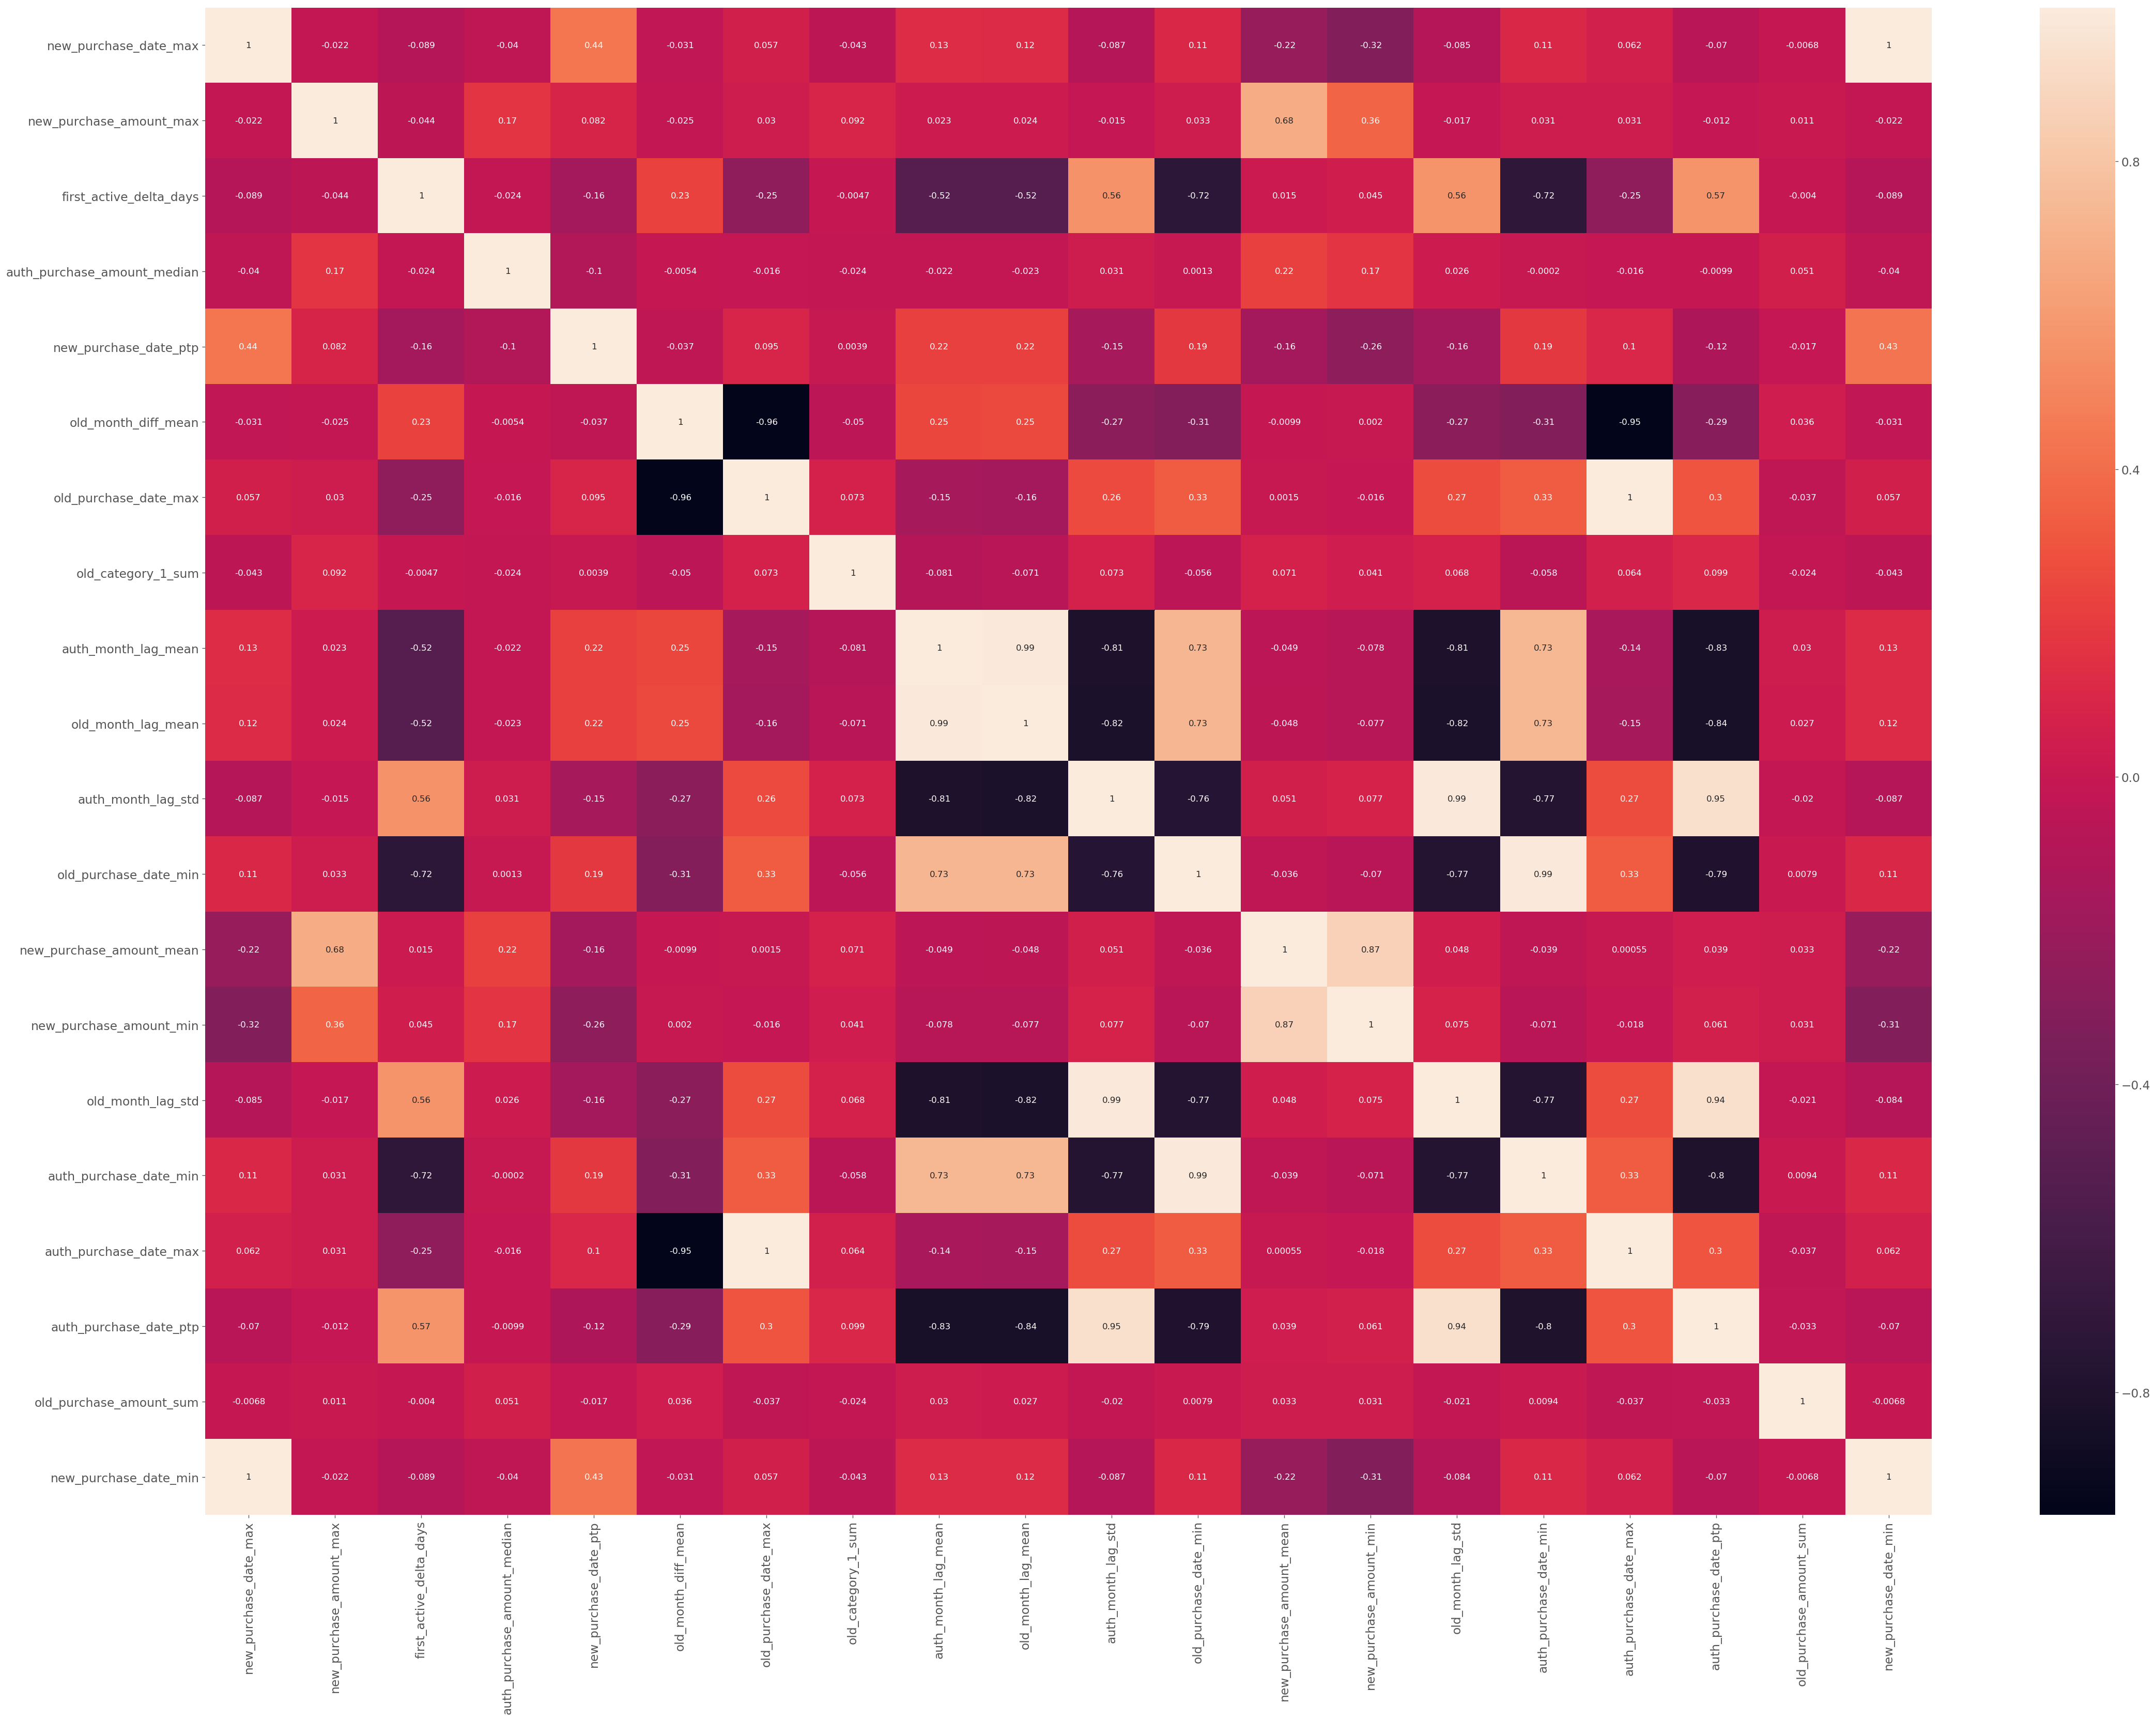

In [20]:
train_sm = train[cols[:20]][:5000]
corr = train_sm.corr()
plt.figure(num=None, figsize=(40,30), dpi=120, facecolor='w', edgecolor='k')
sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True
          )

## Let's use Sparse PCA for more Feature Selection

In [21]:
# Let's remove data with a LASSO coefficient of 0
del train['old_month_diff_max']
del test['old_month_diff_max']

del train['new_month_lag_min']
del test['new_month_lag_min']

del train['auth_month_diff_max']
del test['auth_month_diff_max']

del train['new_month_diff_max']
del test['new_month_diff_max']

del train['new_month_lag_max']
del test['new_month_lag_max']

del train['auth_authorized_flag_sum']
del test['auth_authorized_flag_sum']

In [22]:
# Let's now train a SparsePCA and take the SPCA that explains 80% of the variance
normalizer = StandardScaler()
normalizer.fit(train)
norm_train_data = normalizer.transform(train)
normalizer.fit(test)
norm_test_data = normalizer.transform(test)

sPCA = MiniBatchSparsePCA(ridge_alpha=10, n_jobs=-1)
sPCA.fit(norm_train_data)
train_sPCA = sPCA.transform(norm_train_data)
test_sPCA = sPCA.transform(norm_test_data)

In [23]:
train_sPCA_cop = np.where(train_sPCA > 0.0001, train_sPCA, 0)
test_sPCA_cop = np.where(test_sPCA > 0.0001, test_sPCA, 0)
ratio_spar = train_sPCA_cop[train_sPCA_cop != 0].shape[0]/(train_sPCA.shape[0]*train_sPCA.shape[1])
print('We compress the amount of data by %.02f%% using Sparse Representation'%(100-ratio_spar*100))

We compress the amount of data by 54.26% using Sparse Representation


## Add the first 10 principal components as features

In [24]:
for i in range(10):
    train['sPCA_'+str(i+1)] = train_sPCA_cop[:,i]
    test['sPCA_'+str(i+1)] = test_sPCA_cop[:,i]

## Train and test model using ALL engineered features

In [25]:
print(len(train.columns))
for col in train.columns:
    print("'{}',".format(col))

112
'feature_3',
'first_active_delta_days',
'feature_1_1',
'feature_1_2',
'feature_1_3',
'feature_1_4',
'feature_1_5',
'feature_2_1',
'feature_2_2',
'feature_2_3',
'old_purchase_amount_sum',
'old_purchase_amount_mean',
'old_purchase_amount_min',
'old_purchase_amount_max',
'old_purchase_amount_std',
'old_subsector_id_nunique',
'old_merchant_category_id_nunique',
'old_merchant_id_nunique',
'old_installments_sum',
'old_installments_mean',
'old_city_id_nunique',
'old_state_id_nunique',
'old_category_1_sum',
'old_category_2_1.0_sum',
'old_category_2_2.0_sum',
'old_category_2_3.0_sum',
'old_category_2_4.0_sum',
'old_category_2_5.0_sum',
'old_category_3_A_sum',
'old_category_3_B_sum',
'old_category_3_C_sum',
'old_month_lag_mean',
'old_month_lag_min',
'old_month_lag_max',
'old_month_lag_std',
'old_authorized_flag_sum',
'old_month_diff_mean',
'old_month_diff_min',
'old_month_diff_std',
'old_purchase_date_ptp',
'old_purchase_date_min',
'old_purchase_date_max',
'new_purchase_amount_sum',
'new_pur

## Test area to play with different sets of features

In [26]:
def feature_play():
    
    np.random.seed(0)
    #This is just to play around with different engineered features. 
    
    data_len = len(train)
    mask = np.random.rand(data_len) < 0.8

    train_data = train.values[mask]
    train_labels = target.values.flatten()[mask]
    val_data = train.values[~mask]
    val_labels = target.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_val = val_data
    y_val = val_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_reg)

    y_mean = train_labels.mean()
    y_val_mean = val_labels.mean()

    print("Using the new set of features, with Sparse PC, the Mean Squared Error is: {:0.3f}".format(mse))
    
    return mse
    
play_mse = feature_play()

Using the new set of features, with Sparse PC, the Mean Squared Error is: 13.759


## Final Write of new Files

In [27]:
train.to_pickle('./input/selected_train.pkl', protocol=2)
test.to_pickle('./input/selected_test.pkl', protocol=2)